In [344]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm

In [228]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [229]:
def Rastrigin_function(
    x: np.array,
    A: float = 10,
) -> np.array:
    y = (
        A * 2
        + x[0] ** 2
        - A * np.cos(2 * np.pi * x[0])
        + x[1] ** 2
        - A * np.cos(2 * np.pi * x[1])
    )
    return y


def Rastrigin_gradient(
    x: np.array,
    A: float = 10,
) -> np.array:
    df_dx = 2 * x[0] + 2 * np.pi * A * np.sin(2 * np.pi * x[0])
    df_dy = 2 * x[1] + 2 * np.pi * A * np.sin(2 * np.pi * x[1])
    return np.array([df_dx, df_dy])

In [230]:
def Rosenbrock_function(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:
    y = (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2
    return y


def Rosenbrock_gradient(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:
    df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0] ** 2)
    df_dy = 2 * b * (x[1] - x[0] ** 2)
    return np.array([df_dx, df_dy])


def normalized_Rosenbrock_function(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:
    y = ((a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2) / 1000
    return y


def normalized_Rosenbrock_gradient(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:
    df_dx = (-2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0] ** 2)) / 1000
    df_dy = (2 * b * (x[1] - x[0] ** 2)) / 1000
    return np.array([df_dx, df_dy])

In [231]:
def sphere_function(
    x: np.array,
    A: float = 1,
    B: float = 1,
) -> np.array:
    y = A * x[0] ** 2 + B * x[1] ** 2
    return y


def sphere_gradient(
    x: np.array,
    A: float = 1,
    B: float = 1,
) -> np.array:
    df_dx = 2 * A * x[0]
    df_dy = 2 * B * x[1]
    return np.array([df_dx, df_dy])

In [358]:
def Booths_function(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:
    y = (x[0] + 2 * x[1] - 7)**2 + (2 * x[0] + x[1] - 5)**2
    return y

def Booths_gradient(
    x: np.array,
    a: float = 1,
    b: float = 100,
) -> np.array:
    df_dx = 2 * (x[0] + 2 * x[1] - 7) + 4 * (2 * x[0] + x[1] - 5)
    df_dy = 4 * (x[0] + 2 * x[1] - 7) + 2 * (2 * x[0] + x[1] - 5)
    return np.array([df_dx, df_dy])

In [350]:
def solution_visualization(
    function: callable,
    x_seqs: list = None,
    x_star: np.array = None,
    xlim: tuple = (-5, 5),
    ylim: tuple = (-5, 5),
    step: float = 0.01,
    flat: bool = True,
    labels: list = [],
    cmap: str = "viridis",
):
    x1 = np.arange(xlim[0], xlim[1], step)
    x2 = np.arange(ylim[0], ylim[1], step)
    x = np.meshgrid(x1, x2)

    y = function(x)

    if flat:
        fig, ax = plt.subplots()
        fig.set_figheight(10)
        fig.set_figwidth(10)

        im = ax.imshow(
            y,
            extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
            origin="lower",
            cmap=cmap,
            aspect="equal",
        )

        im = ax.imshow(
            y,
            extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
            origin="lower",
            cmap=cmap,
            norm=AsinhNorm(),
            aspect="equal",
        )

        fig.colorbar(im, ax=ax, shrink=0.5, aspect=5)

        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])

        for x_seq, label in zip(x_seqs, labels):
            if x_seq is not None:
                ax.plot(x_seq[:, 0], x_seq[:, 1], label=label)
                ax.scatter(x_seq[0, 0], x_seq[0, 1], c="black")
                ax.scatter(x_seq[-1, 0], x_seq[-1, 1], c="r")

        if x_star is not None:
            ax.scatter(x_star[0], x_star[1], marker=(5, 1), c="y")

        plt.legend()

    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        surf = ax.plot_surface(
            x[0], x[1], y, facecolors=plt.cm.viridis(y), rstride=1, cstride=1
        )

        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        plt.show()

In [351]:
class GradientOptimizer:
    def __init__(
        self,
        function: callable,
        initial_point: np.array,
        grad_function: callable = None,
        method: str = "GD",
        grad_calculation: str = "",
        stop_criteria: str = "point_norm",
        max_iteration: int = 100,
        alpha: float = 1e-4,
        beta_1: float = 0.9,
        beta_2: float = 0.99,
        eps: float = 1e-8,
        eps_stop: float = 1e-3,
    ):
        self.function = function
        self.initial_point = initial_point
        self.grad_function = grad_function
        self.method = method
        self.grad_calculation = grad_calculation
        self.stop_criteria = stop_criteria
        self.max_iteration = max_iteration
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.eps_stop = eps_stop

    def step(self):
        grad = self.grad_function(self.point_seq[-1])

        if self.method == "GD":
            self.next_point = self.point_seq[-1] - self.alpha * grad

        if self.method == "Momentum":
            if len(self.point_seq) > 1:
                self.next_point = (
                    self.point_seq[-1]
                    - self.alpha * grad
                    + self.beta_1 * (self.point_seq[-1] - self.point_seq[-2])
                )
            else:
                self.next_point = self.point_seq[-1] - self.alpha * grad

        if self.method == "NesterovMomentum":
            if len(self.point_seq) > 1:
                grad = self.grad_function(
                    self.point_seq[-1] + self.beta_1 * self.curr_momentum
                )
                self.curr_momentum = (
                    self.beta_1 * self.curr_momentum - self.alpha * grad
                )
            else:
                grad = self.grad_function(self.point_seq[-1])
                self.curr_momentum = -self.alpha * grad

            self.next_point = self.point_seq[-1] + self.curr_momentum

        if self.method == "RMSProp":
            if len(self.point_seq) > 1:
                self.curr_adaptation = (
                    self.beta_2 * self.curr_adaptation + (1 - self.beta_2) * grad**2
                )
                self.next_point = self.point_seq[-1] - self.alpha * grad / np.sqrt(
                    self.curr_adaptation + self.eps
                )
            else:
                self.curr_adaptation = 1
                self.next_point = self.point_seq[-1] - self.alpha * grad

        if self.method == "Adam":
            if len(self.point_seq) > 1:
                self.curr_momentum = (
                    self.beta_1 * self.curr_momentum + (1 - self.beta_1) * grad
                )
                self.curr_adaptation = (
                    self.beta_2 * self.curr_adaptation + (1 - self.beta_2) * grad**2
                )
                self.next_point = self.point_seq[
                    -1
                ] - self.alpha * self.curr_momentum / np.sqrt(
                    self.curr_adaptation + self.eps
                )
            else:
                self.curr_adaptation = 1
                self.curr_momentum = -self.alpha * grad
                self.next_point = self.point_seq[-1] - self.alpha * grad

        self.next_value = self.function(self.next_point)

        if self.stop_criteria == "point_norm":
            self.done = (
                np.linalg.norm(self.point_seq[-1] - self.next_point) < self.eps_stop
            )

        if self.stop_criteria == "value_norm":
            self.done = (
                np.linalg.norm(self.value_seq[-1] - self.next_value) < self.eps_stop
            )

        if self.stop_criteria == "grad_norm":
            self.done = np.linalg.norm(grad) < self.eps_stop

    def find_minimum(self):
        if self.grad_function is None:
            pass

        self.point_seq = []
        self.value_seq = []
        self.point_seq.append(self.initial_point)
        self.value_seq.append(self.function(self.initial_point))

        for _ in range(self.max_iteration):
            self.step()
            self.point_seq.append(self.next_point)
            self.value_seq.append(self.next_value)
            if self.done:
                break

        return np.array(self.point_seq), np.array(self.value_seq)

In [366]:
def hyperparameter_optimization(optimizer: GradientOptimizer) -> None:
    alphas = np.linspace(1e-2, 1e-3, 1000)
    min_value = +np.inf

    for alpha in alphas:
        optimizer.alpha = alpha
        x_seq, y_seq = optimizer.find_minimum()
        if y_seq[-1] < min_value:
            best_alpha = alpha
            min_value = y_seq[-1]

    optimizer.alpha = best_alpha

In [367]:
def plot_best_solution(
    optimizer: GradientOptimizer,
    xlim: tuple,
    ylim: tuple,
    x_star: np.array = None,
) -> None:
    hyperparameter_optimization(optimizer)

    x_seq, y_seq = optimizer.find_minimum()
    print(x_seq.shape)

    solution_visualization(
        Rosenbrock_function, x_seq, x_star, xlim, ylim, cmap="viridis"
    )
    print(x_seq[-1, :])
    print(y_seq[-1])

In [368]:
def compare_methods(
    function: callable,
    initial_point: np.array,
    xlim: tuple,
    ylim: tuple,
    x_star: np.array = None,
    grad_function: callable = None,
    cmap: str = "viridis",
) -> None:
    methods = ["GD", "Momentum", "NesterovMomentum", "RMSProp", "Adam"]

    x_seqs = []
    y_seqs = []

    for method in methods:
        optimizer = GradientOptimizer(function, initial_point, grad_function, method)
        hyperparameter_optimization(optimizer)

        x_seq, y_seq = optimizer.find_minimum()
        x_seqs.append(x_seq)
        y_seqs.append(y_seq)

        print(
            f"{method}: steps = {x_seq.shape[0]}, value = {y_seq[-1]}, lr = {optimizer.alpha}"
        )

    solution_visualization(
        function, x_seqs, x_star, xlim, ylim, cmap=cmap, labels=methods
    )

GD: steps = 71, value = 0.042334858197740625, lr = 0.0027477477477477474
Momentum: steps = 101, value = 0.002851171499799431, lr = 0.0025855855855855857
NesterovMomentum: steps = 60, value = 1.6356884571288934e-07, lr = 0.001396396396396396
RMSProp: steps = 101, value = 4.2002953647620656, lr = 0.0018918918918918916
Adam: steps = 101, value = 4.29941104077448, lr = 0.0019009009009009013


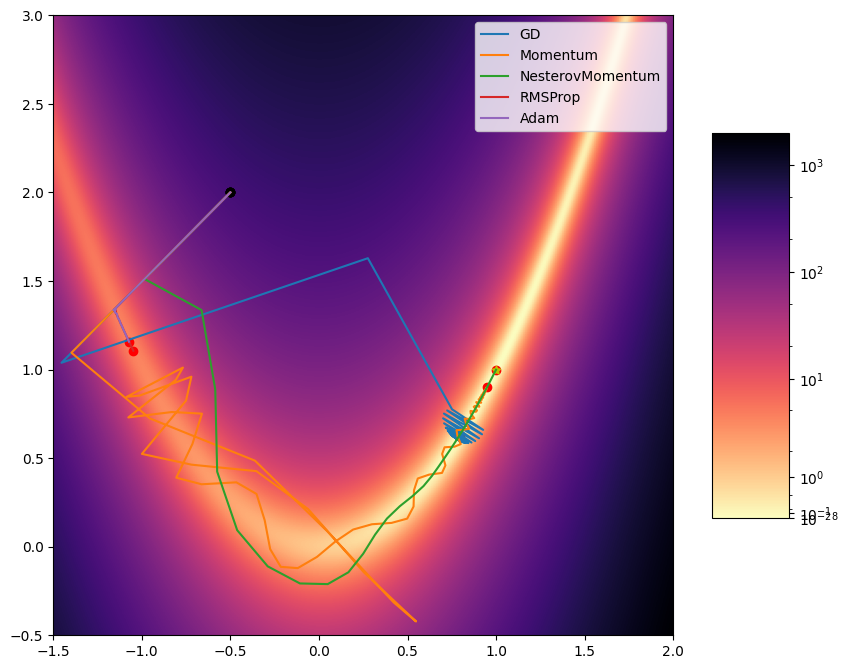

In [369]:
initial_point = np.array([-0.5, 2.0])
xlim = (-1.5, 2)
ylim = (-0.5, 3)
x_star = np.array([1, 1])

cmap = "magma_r"

compare_methods(
    function=Rosenbrock_function,
    grad_function=Rosenbrock_gradient,
    initial_point=initial_point,
    xlim=xlim,
    ylim=ylim,
    x_star=x_star,
    cmap=cmap,
)

GD: steps = 101, value = 0.439698665143039, lr = 0.01
Momentum: steps = 101, value = 9.478427426856591e-07, lr = 0.0016486486486486478
NesterovMomentum: steps = 101, value = 1.9808157477672016e-07, lr = 0.0017387387387387387
RMSProp: steps = 101, value = 6.878612137235388, lr = 0.01
Adam: steps = 101, value = 8.555811873466501, lr = 0.01


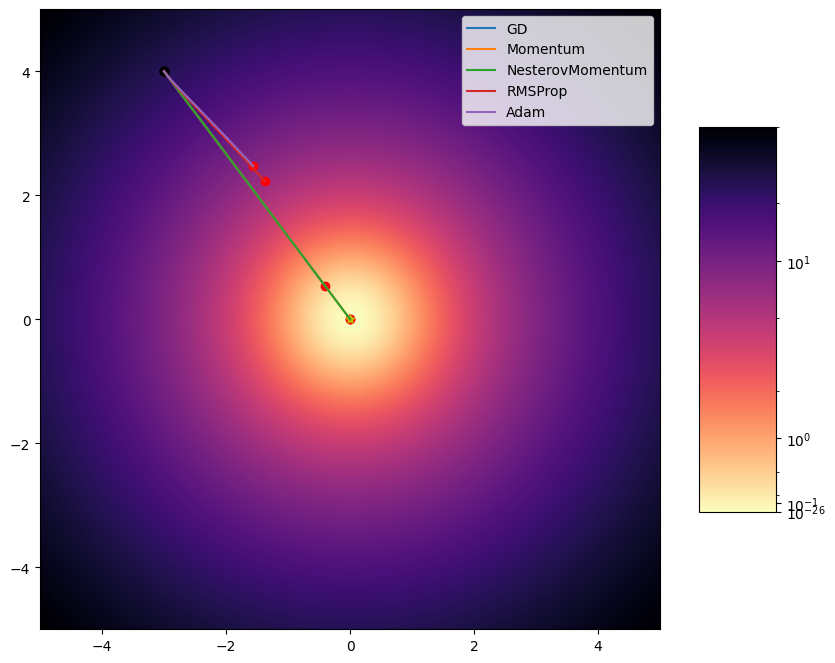

In [370]:
initial_point = np.array([-3, 4])
xlim = (-5, 5)
ylim = (-5, 5)
x_star = np.array([0, 0])

compare_methods(
    function=sphere_function,
    grad_function=sphere_gradient,
    initial_point=initial_point,
    xlim=xlim,
    ylim=ylim,
    x_star=x_star,
    cmap=cmap,
)

GD: steps = 101, value = 0.07914575972574972, lr = 0.01
Momentum: steps = 101, value = 8.881724158848367e-06, lr = 0.00481081081081081
NesterovMomentum: steps = 87, value = 4.9882944643133337e-05, lr = 0.006630630630630631
RMSProp: steps = 101, value = 133.0693557860948, lr = 0.01
Adam: steps = 101, value = 166.25807964991674, lr = 0.01


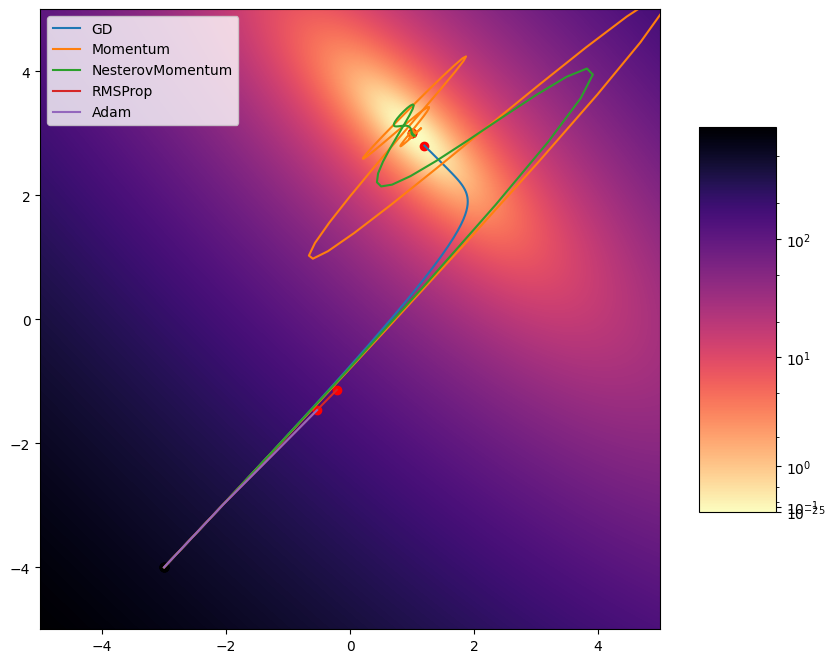

In [371]:
initial_point = np.array([-3, -4])
xlim = (-5, 5)
ylim = (-5, 5)
x_star = np.array([1, 3])

cmap = "magma_r"

compare_methods(
    function=Booths_function,
    grad_function=Booths_gradient,
    initial_point=initial_point,
    xlim=xlim,
    ylim=ylim,
    x_star=x_star,
    cmap=cmap,
)